This script trains an autoencoder to project the data on 2 latent dimensions, obtained projecting the data on a 2-dimensional nonlinear manifold. We observe that:

1. The regressors distribution is clearly heterogeneous, different for every role --> careful feature selection
2. Most importantly for the task, the outliers are distributional anomalies: they are not just high valued, but structurally different in feature space --> training a separate model on these points and combine predictions could reduce overall RMSE

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import random

In [2]:
# === Set seeds for reproducibility ===
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [3]:
data = pd.read_csv('../../data/preprocessed/training.csv')
y = data['value_eur']
X = data.drop(columns=['value_eur'])

In [4]:
# scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Convert to PyTorch tensor ===
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [5]:
# === Define Autoencoder ===
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# === Initialize model, loss, optimizer ===
input_dim = X_tensor.shape[1]
latent_dim = 2
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Train the autoencoder ===
model.train()
for epoch in range(50):
    epoch_loss = 0
    for (x_batch,) in loader:
        optimizer.zero_grad()
        x_hat = model(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss / len(loader):.6f}")

# === Extract compressed features ===
model.eval()
with torch.no_grad():
    compressed_features = model.encoder(X_tensor).numpy()

print("Compressed feature shape:", compressed_features.shape)


Epoch 0: Loss = 0.654134
Epoch 10: Loss = 0.384212
Epoch 20: Loss = 0.375503
Epoch 30: Loss = 0.370543
Epoch 40: Loss = 0.367198
Compressed feature shape: (15333, 2)


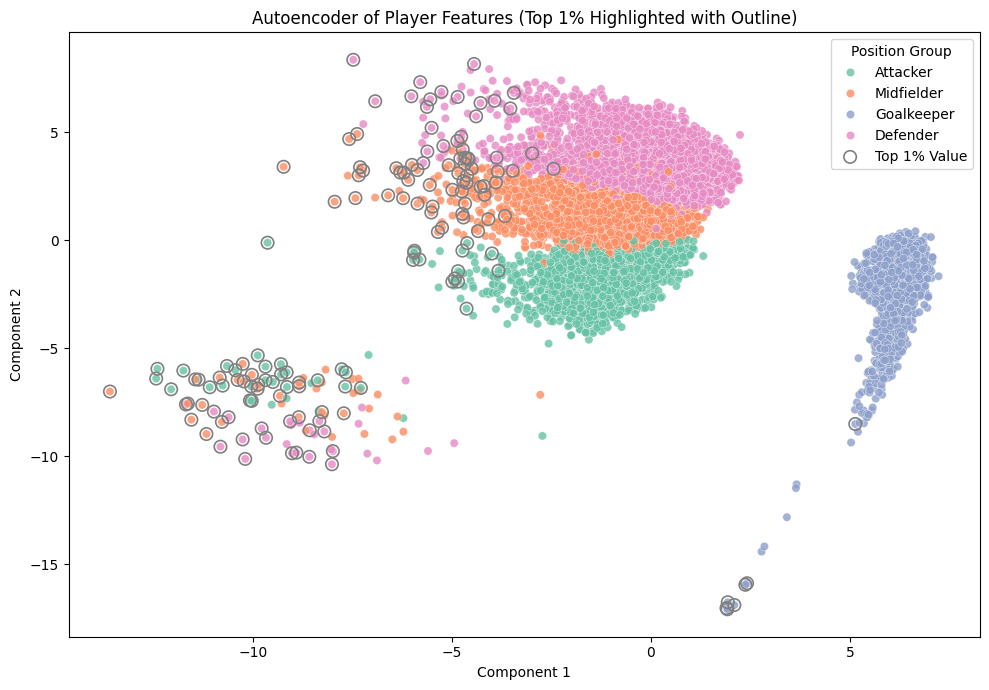

In [6]:
# === Define position groups and top 20% flag ===
position_cols = [
    'position_group_Goalkeeper',
    'position_group_Defender',
    'position_group_Midfielder',
    'position_group_Attacker'
]

X = data

# === Identify top 20% players by value ===
top_flag = X['value_eur'] >= X['value_eur'].quantile(0.99)

# === Position labels from dummies ===
position_dummies = X[position_cols]
position_labels = position_dummies.idxmax(axis=1).str.replace('position_group_', '')

# === Build DataFrame for plotting ===
plot_df = pd.DataFrame(compressed_features, columns=['Comp1', 'Comp2'])
plot_df['Position'] = position_labels
plot_df['Top'] = top_flag

# === Plot base scatter with Seaborn ===
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df,
    x='Comp1',
    y='Comp2',
    hue='Position',
    palette='Set2',
    alpha=0.8,
    edgecolor='white',
    linewidth=0.3
)

# === Overlay top players with edge outline ===
top_df = plot_df[plot_df['Top']]
plt.scatter(
    top_df['Comp1'],
    top_df['Comp2'],
    facecolors='none',     
    edgecolors='gray',     
    linewidths=1.2,
    s=80,
    label='Top 1% Value'
)

plt.title("Autoencoder of Player Features (Top 1% Highlighted with Outline)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Position Group", loc='best')
plt.tight_layout()
plt.show()
